# Imports & Constants

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Set reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
# Path to dataset
dataset_path = "leapGestRecog"

# Gesture classes (folder names)
CLASSES = [
    '01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb',
    '06_index', '07_ok', '08_palm_moved', '09_c', '10_down'
]

IMG_SIZE = 64  # standardized image size
data = []
labels = []

for subject in os.listdir(dataset_path):
    subject_path = os.path.join(dataset_path, subject)
    if os.path.isdir(subject_path):
        for gesture in CLASSES:
            gesture_path = os.path.join(subject_path, gesture)
            if os.path.isdir(gesture_path):
                for img_name in os.listdir(gesture_path):
                    img = cv2.imread(os.path.join(gesture_path, img_name), cv2.IMREAD_GRAYSCALE)
                    if img is not None:
                        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                        data.append(img)
                        labels.append(CLASSES.index(gesture))

data = np.array(data) / 255.0  # normalize to [0,1]
data = data.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # add channel
labels = to_categorical(labels, num_classes=len(CLASSES))

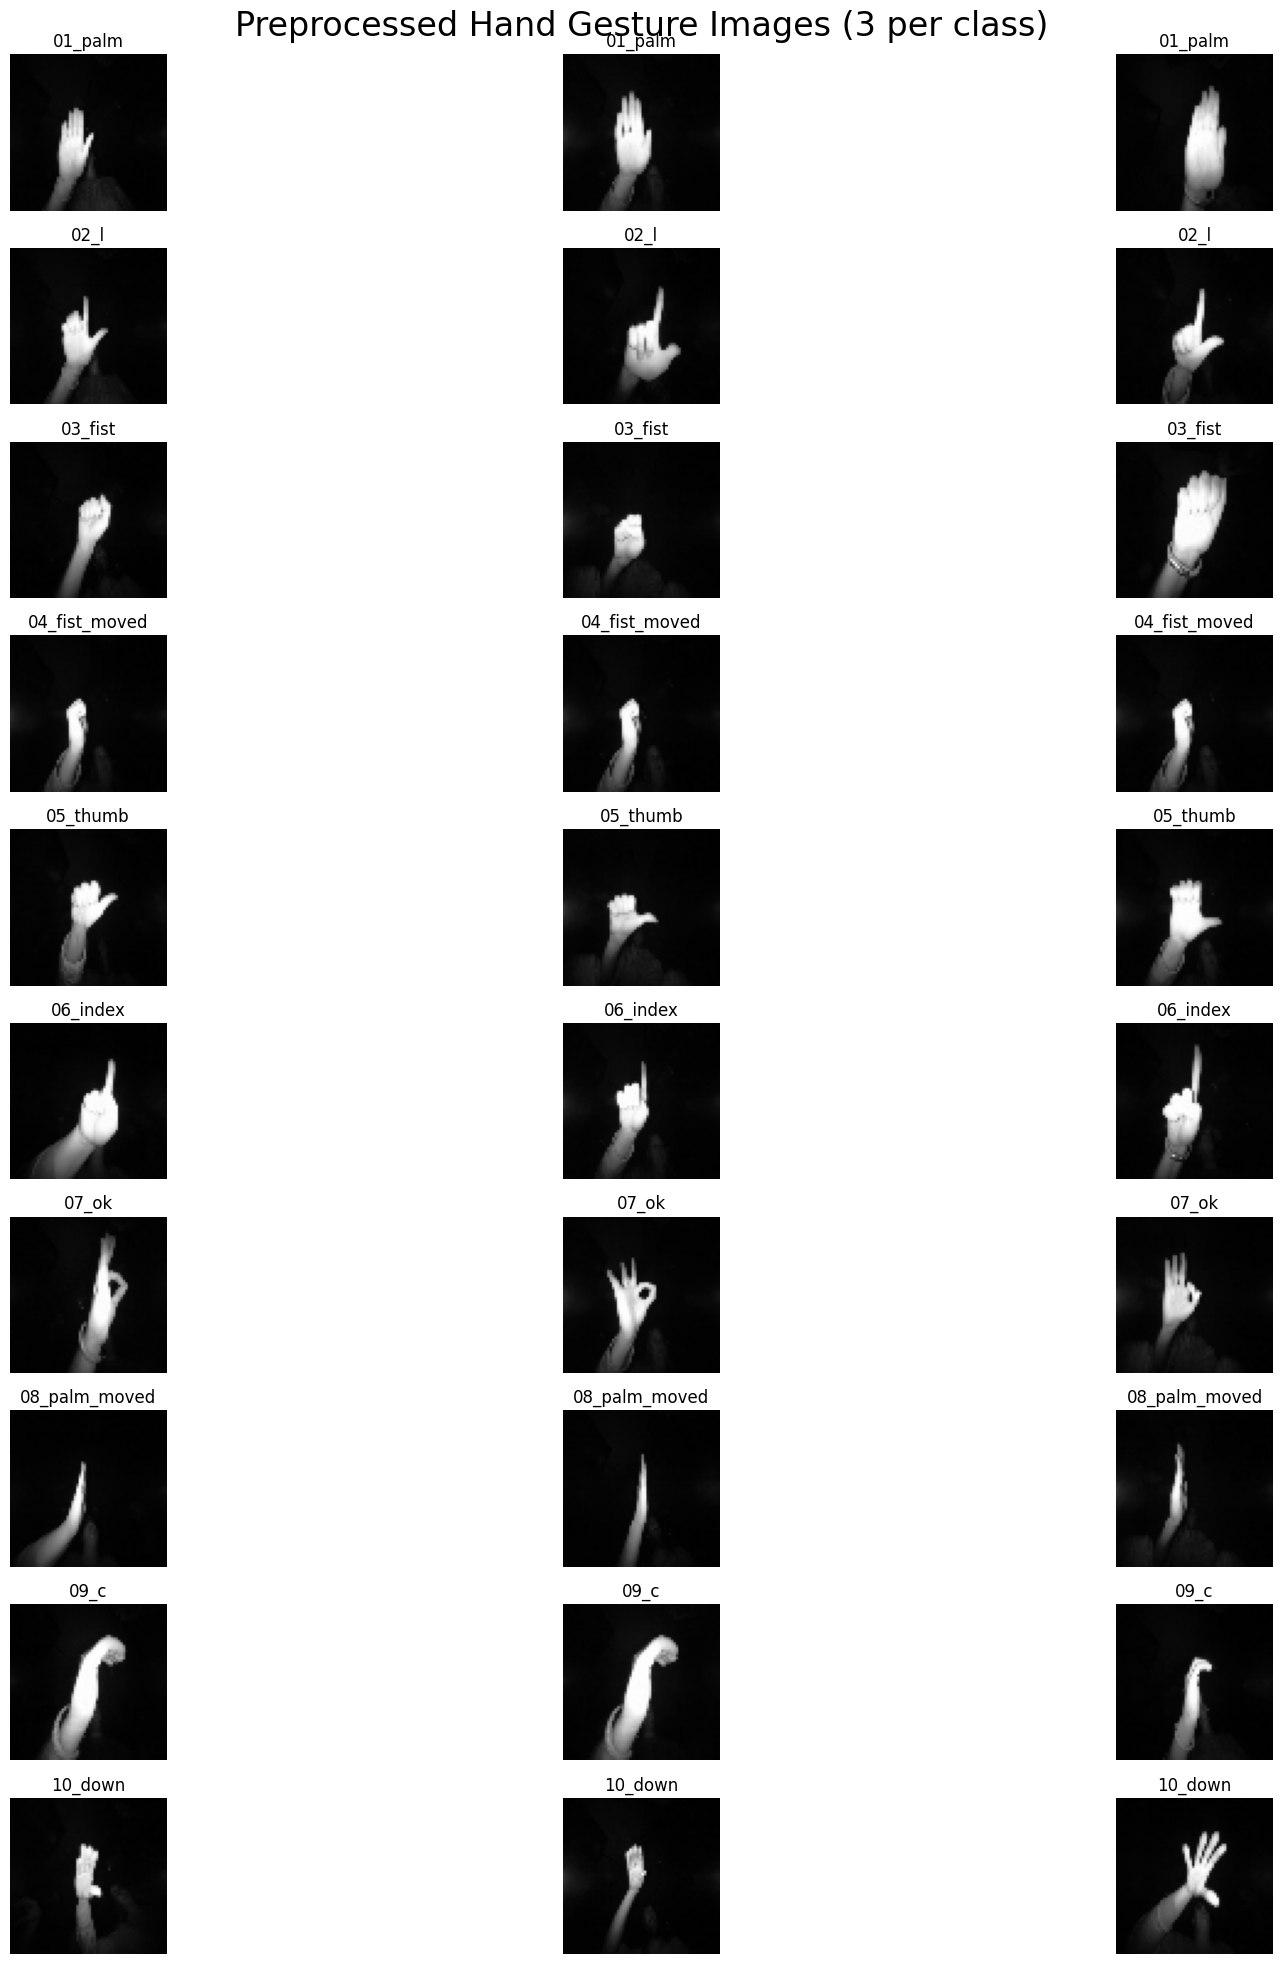

In [ ]:
# Number of images to show per class
images_per_class = 3

plt.figure(figsize=(20, 20))
plot_index = 1

for class_index, class_name in enumerate(CLASSES):

    # Get indices of images belonging to this class
    class_indices = np.where(np.argmax(labels, axis=1) == class_index)[0]

    # Randomly pick 3 images from this class
    selected_indices = np.random.choice(class_indices, images_per_class, replace=False)

    for idx in selected_indices:
        plt.subplot(len(CLASSES), images_per_class, plot_index)
        plt.imshow(data[idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
        plt.title(class_name)
        plt.axis("off")
        plot_index += 1

plt.suptitle("Preprocessed Hand Gesture Images (3 per class)", fontsize=24)
plt.tight_layout()
plt.show()

In [ ]:
print("Min pixel value:", data.min())
print("Max pixel value:", data.max())

Min pixel value: 0.00392156862745098
Max pixel value: 0.9921568627450981


# Counting the images in each class

In [ ]:
import pandas as pd
import numpy as np

# Convert one-hot labels back to class indices
label_indices = np.argmax(labels, axis=1)

# Count samples per class
class_counts = pd.Series(label_indices).value_counts().sort_index()

# Display counts with class names
for i, class_name in enumerate(CLASSES):
    print(f"{class_name}: {class_counts[i]} images")

01_palm: 2000 images
02_l: 2000 images
03_fist: 2000 images
04_fist_moved: 2000 images
05_thumb: 2000 images
06_index: 2000 images
07_ok: 2000 images
08_palm_moved: 2000 images
09_c: 2000 images
10_down: 2000 images


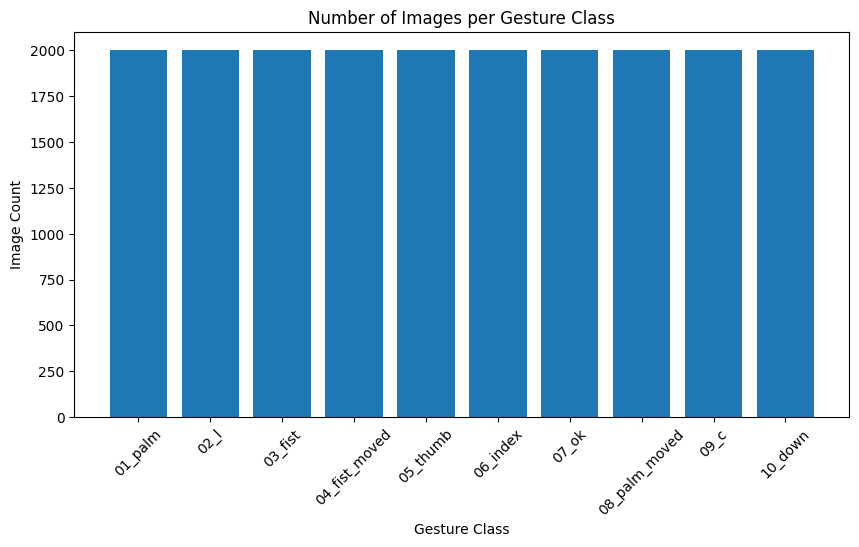

In [ ]:
plt.figure(figsize=(10,5))
plt.bar(CLASSES, class_counts.values)
plt.xticks(rotation=45)
plt.title("Number of Images per Gesture Class")
plt.ylabel("Image Count")
plt.xlabel("Gesture Class")
plt.show()

# Train–Validation Split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    data, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)

Train: (16000, 64, 64, 1)
Validation: (4000, 64, 64, 1)


# Build & Train CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(CLASSES), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,866 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 101s 198ms/step - accuracy: 0.6852 - loss: 0.9258 - val_accuracy: 0.9975 - val_loss: 0.0109
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 139s 193ms/step - accuracy: 0.9805 - loss: 0.0602 - val_accuracy: 0.9995 - val_loss: 0.0026
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 139s 188ms/step - accuracy: 0.9897 - loss: 0.0330 - val_accuracy: 0.9998 - val_loss: 8.6819e-04
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 94s 187ms/step - accuracy: 0.9930 - loss: 0.0225 - val_accuracy: 1.0000 - val_loss: 5.2898e-04
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 138s 180ms/step - accuracy: 0.9936 - loss: 0.0192 - val_accuracy: 0.9998 - val_loss: 6.4031e-04
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 140s 176ms/step - accuracy: 0.9959 - loss: 0.0134 - val_accuracy: 0.9992 - val_loss: 0.0023
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 86s 171ms/step - accuracy: 0.9954 - loss: 0.0135 - val_accuracy: 1.0000 - val_loss: 3.2234e-04
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 87s 175ms/step - accur

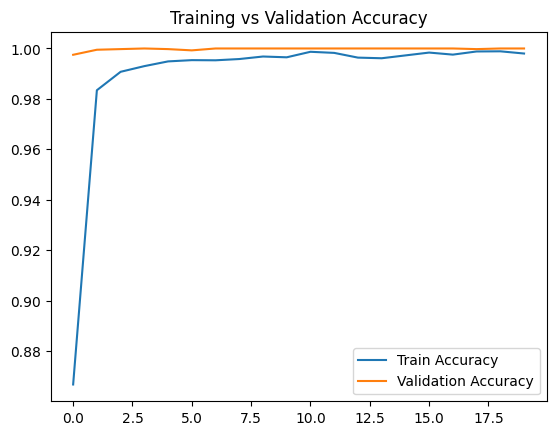

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()

In [ ]:
model.save("hand_gesture_cnn.keras")

# Predict From a New Image

In [ ]:
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print("Uploaded image:", image_path)

Saving hand.png to hand.png
Uploaded image: hand.png


In [ ]:
def predict_gesture_dynamic(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError("Image could not be read")

    img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img_normalized = img_resized / 255.0
    img_reshaped = img_normalized.reshape(1, IMG_SIZE, IMG_SIZE, 1)

    prediction = model.predict(img_reshaped)
    class_id = np.argmax(prediction)
    confidence = np.max(prediction)

    plt.figure(figsize=(4,4))
    plt.imshow(img_resized, cmap='gray')
    plt.title(f"Prediction: {CLASSES[class_id]}\nConfidence: {confidence:.2f}")
    plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


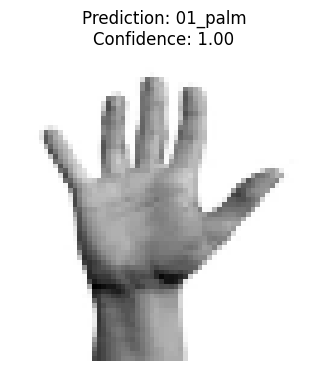

In [ ]:
predict_gesture_dynamic(image_path)

In [ ]:
from google.colab import files
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print("Uploaded image:", image_path)

Saving hand-t.jpg to hand-t.jpg
Uploaded image: hand-t.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


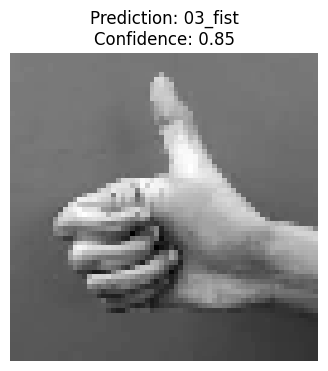

In [ ]:
predict_gesture_dynamic(image_path)

In [ ]:
uploaded = files.upload()
image_path = list(uploaded.keys())[0]
print("Uploaded image:", image_path)

Saving hand-ok.jpg to hand-ok.jpg
Uploaded image: hand-ok.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


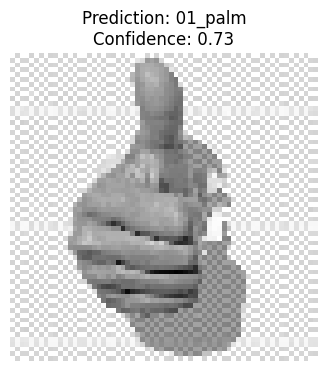

In [ ]:
predict_gesture_dynamic(image_path)

## Analyze training history



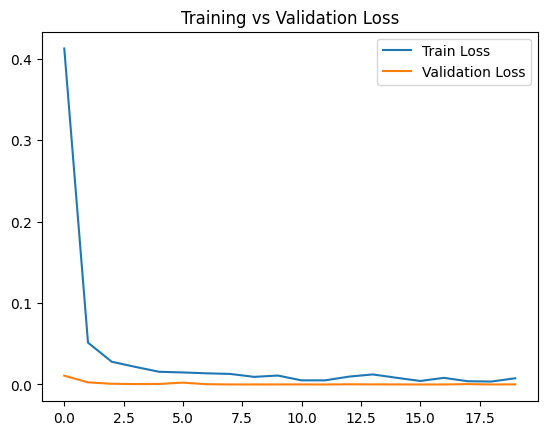

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

### Optimal Number of Epochs Analysis

From the training history plots for accuracy and loss, we can observe the following:

*   **Accuracy Curves**: Both training and validation accuracy increase rapidly in the initial epochs. The validation accuracy reaches near 100% by approximately the 4th or 5th epoch and remains consistently high thereafter. There are no significant signs of the validation accuracy dropping, which would indicate overfitting.

*   **Loss Curves**: Similarly, both training and validation loss decrease sharply during the first few epochs. The validation loss reaches a very low, stable value around the 4th or 5th epoch. It continues to fluctuate at a minimal level, without showing a clear upward trend that would suggest overfitting.

Given these observations, the model appears to converge very quickly. Training for 20 epochs is likely more than necessary, leading to increased training time without substantial gains in performance or improved generalization. To optimize training time and prevent potential, albeit minor, overfitting (even if not strongly evident here), an optimal number of epochs can be chosen where the model has already achieved high validation accuracy and low validation loss.

**Conclusion**: An optimal number of **5 epochs** should be sufficient for this model. At this point, the model has already achieved excellent performance on the validation set, and further training provides diminishing returns and unnecessarily prolongs the training process. This reduction will significantly decrease the training duration as specified in the task.